# About DSPy

Programming around LLMs without "Prompt Engineering"

-- but wait: you can automatically optimize the promt with ~20 examples


## Created By Stanford NLP Group -- Maintained by Databricks
Paper: https://arxiv.org/abs/2310.03714 

Omar Khattab et al. \
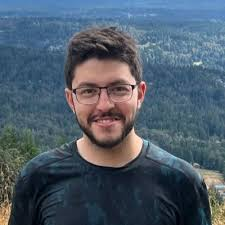  ![Tom](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTIihNHQ0hJF-JFdv9F0X_dEB78p0EhR0uGcFaa0nT54kTs2qmn2Ea4w_sLxREsKMqBuRI&usqp=CAU)




## How it works?

Declarative Programming: When the LLM is a **Module** in your application. \
Instead of thinking about how to prompt, format the output, and then use the LLM, only declare its "Functionality"




# DSPy

In [1]:
!pip install -q dspy

In [2]:
import dspy

from dotenv import load_dotenv
from pprint import pprint
from typing import Literal, Union
load_dotenv()


/gaueko0/users/asalem/anaconda3/envs/py310_transformers4dot49/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## LLM Definition

In [3]:
gpt4o_mini = dspy.LM('gpt-4o-mini')

## LLM Prediction Mode
1. Predict: directly respond with the output
2. Chain of Thought
3. Program of Thought
4. ReAct
6. CodeAct

## Test Time Compute:
1. Thinking Models
2. BestOfN
3. Parallel
4. Refine

## Signature

Like a python method, you need to define the LLM's functionality signature.

(parameter1, parameter2, parameter3) -> output


### String Signatures
Answer a question!

In [4]:
# test connection:
with dspy.context(lm=gpt4o_mini):
    
    direct_prediction = dspy.Predict("question->answer")
    response = direct_prediction(question="What is the capital of France?")
    pprint(f"Answer: {response.answer}")


'Answer: The capital of France is Paris.'


In [5]:
with dspy.context(lm=gpt4o_mini):
    
    direct_prediction = dspy.Predict("question->answer")
    response = direct_prediction(question="Can any form of water be used as a fuel? [Yes/No]")
    pprint(f"Answer: {response.answer}")

'Answer: No'


In [6]:
with dspy.context(lm=gpt4o_mini):
    direct_prediction = dspy.ChainOfThought("question->answer")
    response = direct_prediction(question="Can any form of water be used as a fuel? [Yes/No]")
    pprint(f"Reasoning: {response.reasoning}")
    pprint(f"Answer: {response.answer}")

('Reasoning: Water itself cannot be used as a fuel in the traditional sense '
 'because it is a stable compound made of hydrogen and oxygen. However, water '
 'can be used to produce hydrogen fuel through processes like electrolysis, '
 'where water is split into hydrogen and oxygen. The hydrogen produced can '
 'then be used as a fuel. Therefore, while water cannot directly serve as a '
 'fuel, it can be a source of fuel (hydrogen) when processed appropriately.')
'Answer: No'


## Signatures as a module


In [7]:
class QuestionAnswering(dspy.Signature):
    
    question:  str = dspy.InputField(desc="A user question which you can answer")
    answer: Literal["Yes", "No"] = dspy.OutputField(desc="Your answer to the question")
    
    

In [8]:
with dspy.context(lm=gpt4o_mini):
    
    direct_prediction = dspy.Predict(QuestionAnswering)
    response = direct_prediction(question="Can any form of water be used as a fuel?")
    pprint(f"Answer: {response.answer}")

'Answer: No'


In [9]:
with dspy.context(lm=gpt4o_mini):
    direct_prediction = dspy.ChainOfThought(QuestionAnswering)
    response = direct_prediction(question="Can any form of water be used as a fuel?")
    pprint(f"Reasoning: {response.reasoning}")
    pprint(f"Answer: {response.answer}")

('Reasoning: Water itself cannot be used as a fuel because it is a stable '
 'compound made of hydrogen and oxygen, and it does not release energy when '
 'burned. However, hydrogen extracted from water can be used as a fuel. '
 'Therefore, while water in its natural state cannot be used directly as a '
 'fuel, its components can be utilized in fuel cells or combustion processes. '
 'Thus, the answer to the question is "No."')
'Answer: No'


## Modules

What if we have a multiple-step interactions with the LLM

In [10]:
class MovieSentiment(dspy.Signature):
    
    review: str = dspy.InputField(desc="A user review of a movie")
    sentiment: Literal["Positive", "Negative", "Neutral"] = dspy.OutputField(desc="The sentiment of the review")
    
with dspy.context(lm=gpt4o_mini):
    
    direct_prediction = dspy.Predict(MovieSentiment)
    response = direct_prediction(review="I hated the storyline")
    pprint(f"Sentiment: {response.sentiment}")
    
    response = direct_prediction(review="I enjoyed the acting")
    pprint(f"Sentiment: {response.sentiment}")
    

'Sentiment: Negative'
'Sentiment: Positive'


In [11]:
class SentimentMovieAspect(dspy.Signature):
    
    review: str = dspy.InputField(desc="A user review of a movie")
    sentiment: Literal["Positive", "Negative", "Neutral"] = dspy.InputField(desc="The sentiment of the review")
    aspect: Literal['cinematography', 'acting', 'storyline'] = dspy.OutputField(desc="The aspect of the movie being reviewed")

with dspy.context(lm=gpt4o_mini):

    review = "Leonardo DiCaprio's was phenomenal, he captured the essence of the character perfectly."
    sentiment_predictor = dspy.Predict(MovieSentiment)
    response = sentiment_predictor(review=review)
    pprint(f"Sentiment: {response.sentiment}")

    aspect_analyzer = dspy.ChainOfThought(SentimentMovieAspect)
    response = aspect_analyzer(review=review, sentiment=response.sentiment)
    pprint(f"Aspect: {response.aspect}")


'Sentiment: Positive'
'Aspect: acting'


In [12]:
class MovieSentimentWithAspect(dspy.Module):
    
    
    def __init__(self, lm):
        self.lm = lm
        self.sentiment_predictor = dspy.Predict(MovieSentiment)
        self.aspect_analyzer = dspy.ChainOfThought(SentimentMovieAspect)
        
    def forward(self, review: str) -> Union[Literal["Positive", "Negative", "Neutral"], Literal['cinematography', 'acting', 'storyline']]:
        with dspy.context(lm=self.lm):
            sentiment_response = self.sentiment_predictor(review=review)
            aspect_response = self.aspect_analyzer(review=review, sentiment=sentiment_response.sentiment)
            return sentiment_response.sentiment, aspect_response.aspect
        

In [13]:
sentiment_with_aspect_llm_analyzer = MovieSentimentWithAspect(lm=gpt4o_mini)
sentiment, aspect  = sentiment_with_aspect_llm_analyzer(review="Leonardo DiCaprio's was phenomenal, he captured the essence of the character perfectly.")
print(f"Aspect: {aspect}")
print(f"Sentiment: {sentiment}")

Aspect: acting
Sentiment: Positive


In [14]:
sentiment, aspect  = sentiment_with_aspect_llm_analyzer(review="The camera man was drunk, the shots were terrible.")
print(f"Aspect: {aspect}")
print(f"Sentiment: {sentiment}")

Aspect: cinematography
Sentiment: Negative


In [15]:
sentiment, aspect  = sentiment_with_aspect_llm_analyzer(review="What the hell was that? I want my money back.")
print(f"Aspect: {aspect}")
print(f"Sentiment: {sentiment}")

Aspect: storyline
Sentiment: Negative


# Debugging and Inspection



In [16]:
dspy.history(3)

AttributeError: module 'dspy' has no attribute 'history'